# Notebook para entrenamiento de clasificacion de poses con Mediapipe

In [3]:

import keras
import pandas as pd
from keras import layers, Sequential
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Cargar datos de entrenamiento

In [5]:

train_csv = './csv_train_test/train.csv'
print('[INFO] Loading training data...')
train_df = pd.read_csv(train_csv)
class_list = train_df['Pose_Class'].unique()
class_list = sorted(class_list)
class_number = len(class_list)


x_train = train_df.copy()
y_train = x_train.pop('Pose_Class')
if 'Image_Path' in x_train.columns:
    x_train.pop('Image_Path')
y_train_encoded, class_mapping = y_train.factorize()
x_train = x_train.astype('float64')
y_train = keras.utils.to_categorical(y_train_encoded)

print('[INFO] Data ready...')

[INFO] Loading training data...
[INFO] Data ready...


### Cargar datos de prueba

In [6]:

test_csv = './csv_train_test/test.csv'
print('[INFO] Loading test data...')
test_df = pd.read_csv(test_csv)
x_test = test_df.copy()
y_test = x_test.pop('Pose_Class')
if 'Image_Path' in x_test.columns:
    x_test.pop('Image_Path')
y_test_encoded = pd.Categorical(y_test, categories=class_mapping).codes
x_test = x_test.astype('float64')
y_test = keras.utils.to_categorical(y_test_encoded)

print('[INFO] Loaded Training and Test Datasets')
print(f'Training samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')

[INFO] Loading test data...
[INFO] Loaded Training and Test Datasets
Training samples: 8560
Test samples: 2141


### Creacion y compilacion del modelo

In [7]:
model = Sequential([
    layers.Dense(512, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_number, activation="softmax")
])

print('Model Summary: ')
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/seba2411/miniconda3/envs/mediapipe-class/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-18 15:47:29.550577: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1739904449.552483    8663 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4159 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model Summary: 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,737 (788.04 KB)

 Trainable params: 201,737 (788.04 KB)

 Non-trainable params: 0 (0.00 B)

### Configuracion de callbacks y entrenar

In [8]:
checkpoint_path = 'model.keras'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_best_only=True,
                                           mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=20)

print('[INFO] Model Training Started ...')
history = model.fit(x_train, y_train,
                   epochs=200,
                   batch_size=16,
                   validation_data=(x_test, y_test),
                   callbacks=[checkpoint, earlystopping])

print('[INFO] Model Training Completed')

[INFO] Model Training Started ...
Epoch 1/200


I0000 00:00:1739904465.473243    9385 service.cc:148] XLA service 0x7efab0009610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739904465.473400    9385 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-18 15:47:45.502112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739904465.599278    9385 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-02-18 15:47:46.581324: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 4 bytes spill stores, 4 bytes spill loads



100/535 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5920 - loss: 1.2087

I0000 00:00:1739904468.085068    9385 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


494/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7599 - loss: 0.7149
Epoch 1: val_accuracy improved from -inf to 0.90612, saving model to model.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7669 - loss: 0.6943 - val_accuracy: 0.9061 - val_loss: 0.2626
Epoch 2/200
510/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9319 - loss: 0.2053
Epoch 2: val_accuracy improved from 0.90612 to 0.95423, saving model to model.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9321 - loss: 0.2044 - val_accuracy: 0.9542 - val_loss: 0.1455
Epoch 3/200
516/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9580 - loss: 0.1242
Epoch 3: val_accuracy did not improve from 0.95423
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9579 - loss: 0.1244 - val_accuracy: 0.9538 - val_loss: 0.1534
Epoch 4/200
516/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9703 - loss: 0.0998
Epoch 4: val_accuracy improved from 0.95423 to 0.96030, saving model to model.keras
535/535 ━━━━━

### evaluacion del modelo y analisis de metricas

In [9]:
print("\n[INFO] Evaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=class_mapping))


[INFO] Evaluating on Test Set...

Test Accuracy: 0.9925
Test Loss: 0.0478
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
                precision    recall  f1-score   support

  Fall forward       0.98      0.99      0.99       203
  Fall sitting       1.00      0.99      0.99       264
          Walk       1.00      1.00      1.00       382
      Sit down       0.99      0.99      0.99       229
         Kneel       0.99      0.99      0.99       249
Fall backwards       1.00      1.00      1.00       276
    Fall right       1.00      1.00      1.00       234
Pick up object       0.98      0.99      0.99       109
     Fall left       0.98      0.98      0.98       195

      accuracy                           0.99      2141
     macro avg       0.99      0.99      0.99      2141
  weighted avg       0.99      0.99      0.99      2141



### Visualizacion historial de entrenamiento

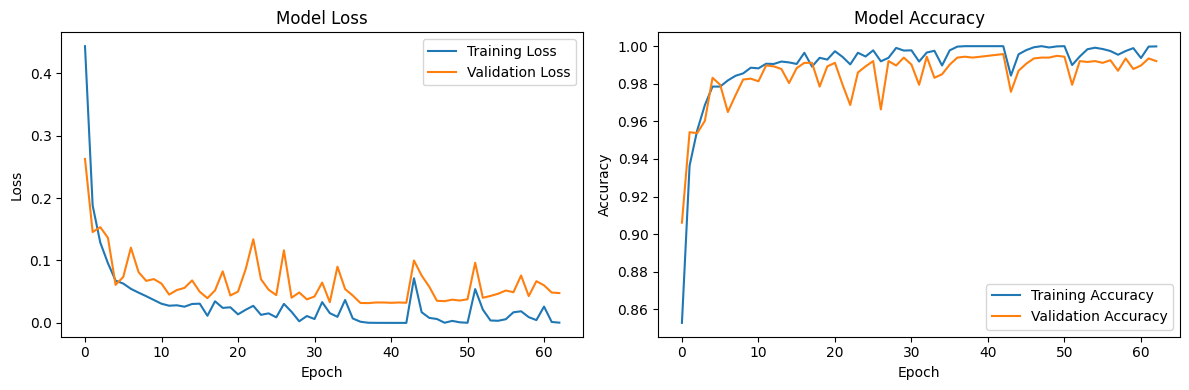

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Matriz de confusion

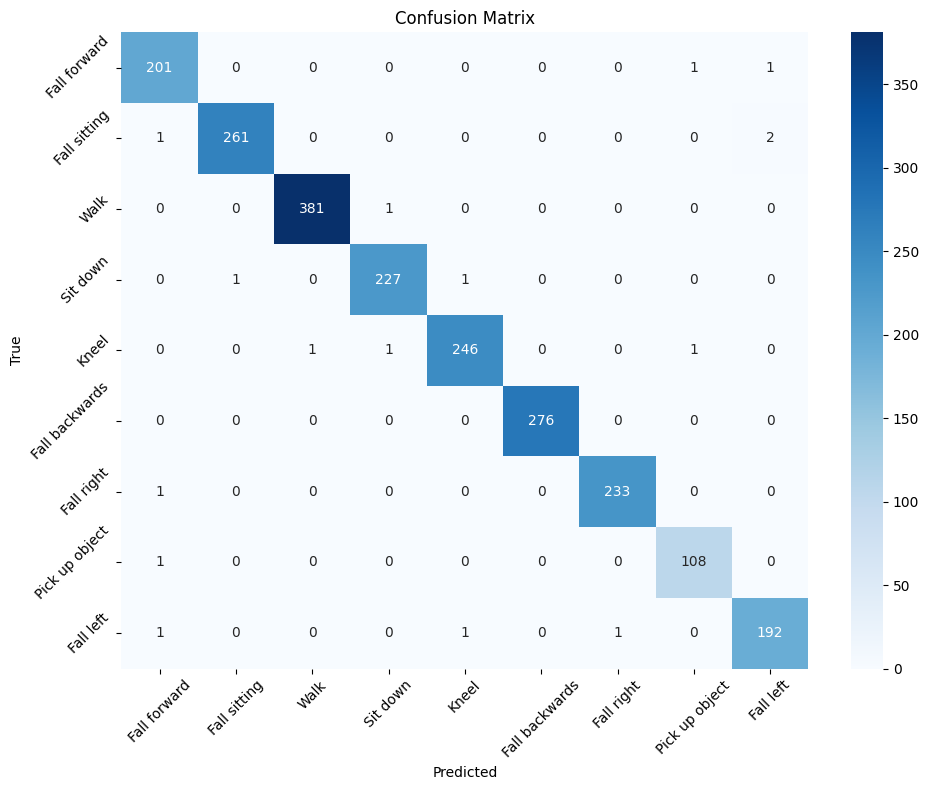

In [11]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping,
            yticklabels=class_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()